## Convolution Model Over Text Data


Using The CNN to Solve this Problem.


### Data Processing And Preparation

**Field** - To define the processing of Data. Parameters of this class helps in Data Processing. 

**Text** - To process the review. 

&emsp; 1. If tokenize = 'spacy' means using the spacy tokenizer else using Whitespace. 

&emsp; 2. batch_first = True, because the CNN layer wants the batch_dimension to be first,However RNN layer wants it to be 2nd. 

**Label** - To process the sentiment. 

In [72]:
import torch
import torchtext
from torchtext import data
from torchtext import datasets
import random
import numpy as np
import torch.nn as nn
from torchtext.vocab import Vocab
import spacy
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization


SEED = 1768

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', batch_first = True)
LABEL = data.LabelField(dtype = torch.float)
nlp = spacy.load('en')

## Download Dataset 

TorchText supports for common datasets used in natural language processing (NLP).

Data will be processed using the fields defined. 

In [75]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL,  path ='data/aclImdb')

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [5]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(f'Number of Validation examples: {len(valid_data)}')

Number of training examples: 17500
Number of testing examples: 25000
Number of Validation examples: 7500


## Build The Vocabulary

**Vocabulary** is look-up tables that specify the index for each unique word in the Data. 

There are over 100000 words in the Review Dataset, But we are considering most frequent 25000 words , (to reduce the processing). 


**Why we are not using the vocabulary provided in the Dataset ?** 
- Because we need the vocabulary created using the train Data only, not the complete Data.

**How we are handling Out of Vocabulary Words ?**
- unk token
    
**How we are handling Length of Sentence ?**
- pad token


In [79]:
MAX_VOCAB_SIZE = 25_000

loaded_vectors = torchtext.vocab.Vectors('data/glove.6B.100d.txt')

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = loaded_vectors, 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [87]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [10]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 203943), (',', 193892), ('.', 166941), ('and', 110594), ('a', 109931), ('of', 101216), ('to', 94280), ('is', 76768), ('in', 61853), ('I', 54686), ('it', 53869), ('that', 49562), ('"', 44401), ("'s", 43847), ('this', 42637), ('-', 37215), ('/><br', 35680), ('was', 35080), ('as', 30578), ('with', 30209)]


In [11]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [12]:
print(LABEL.vocab.stoi)

defaultdict(None, {'pos': 0, 'neg': 1})


## Creating The Iterators

The final step of preparing the data is creating the iterators. We iterate over these in the training/evaluation loop, and they return a batch of examples (indexed and converted into tensors) at each iteration.

In [13]:

BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [14]:
print(len(train_iterator))
print(len(valid_iterator))
print(len(test_iterator))

274
118
391


## Understanding The Batches

In [16]:
batch_train = next(iter(train_iterator))
print(batch_train)
print('\n Shape of Training Data ',batch_train.text.shape)
print('\nRepresntation of First Sentence ')
print(batch_train.text[0,:])

print('\nRepresntation of Labels')
print(batch_train.label)


[torchtext.data.batch.Batch of size 64]
	[.text]:[torch.LongTensor of size 64x1178]
	[.label]:[torch.FloatTensor of size 64]

 Shape of Training Data  torch.Size([64, 1178])

Represntation of First Sentence 
tensor([1582,  206,    3,  ...,    1,    1,    1])

Represntation of Labels
tensor([1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 1., 1., 0., 1., 1., 1.])


## Creating The Model


**Input Channel** - Usually it's 3 (RGB), but in text it's only 1.

**Batch** - Batch Size * Sentence Length

This batch is then passed through the embedding Layer . This embedding layer is the tensor of shape

**Embedding Layer - [batch_size, Sentence Length, embed_dim]**

But **Convolution Layer** Expects input in the format **[batch_size, num_channels, sentence length, embed_dim ]**. So we need it to unsqueeze it. 

**Convolution Layer** - [batch size, n_filters, sent len - filter_sizes[n] + 1]

**Kernel Size** - Size of the filter. Here it would be **[n_grams X embedding_dimension]**


**Pooling Layer** - [batch size, n_filters] Pooling is also 1D. 

**Output Dimension** - 1






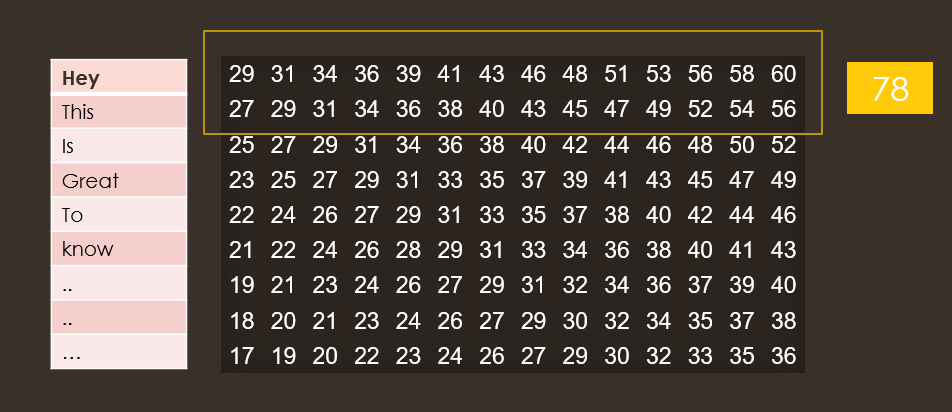





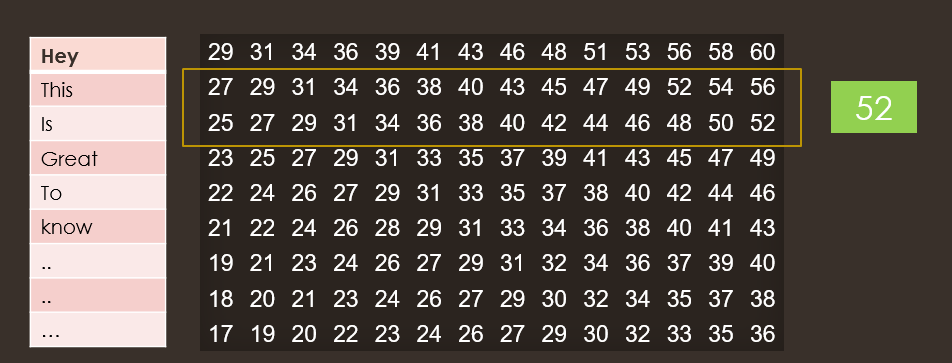

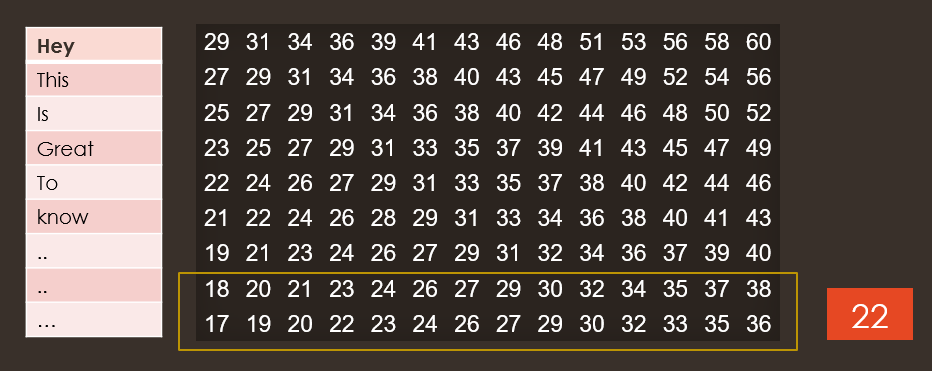

In [29]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [30]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [31]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

## Adding The Unknown Padding Tokens

In [32]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Training The Model

In [33]:

import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [34]:

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [35]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [36]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [37]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [39]:

N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

## Interpreting The Model

In [48]:
model = torch.load('models/imdb-model-cnn.pt')
model.eval()
model = model.to(device)

In [49]:
def forward_with_sigmoid(input):
    return torch.sigmoid(model(input))

In [51]:
test, _ = test_data.split(split_ratio = 0.04)

### Integrated Gradients

In order to apply Integrated Gradients and many other interpretability algorithms on sentences, we need to create a reference (aka baseline) for the sentences and its constituent parts, tokens.

 `TokenReferenceBase` which allows us to generate a reference for each input text using the number of tokens in the text and a reference token index.

To use `TokenReferenceBase` we need to provide a `reference_token_idx`. Since padding is one of the most commonly used references for tokens, padding index is passed as reference token index.

In [45]:
PAD_IND = TEXT.vocab.stoi['pad']
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

In [58]:
lig = LayerIntegratedGradients(model, model.embedding)

In [84]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len = 7, label = 0):
    text = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = forward_with_sigmoid(input_indices).item()
    pred_ind = round(pred)
    #print(pred_ind)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=500, return_convergence_delta=True)

    print('pred: ', LABEL.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            LABEL.vocab.itos[pred_ind],
                            LABEL.vocab.itos[label],
                            LABEL.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))

In [85]:
interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

pred:  neg ( 0.62 ) , delta:  tensor([0.0007])
pred:  pos ( 0.47 ) , delta:  tensor([0.0002])
pred:  neg ( 0.75 ) , delta:  tensor([0.0011])
pred:  pos ( 0.44 ) , delta:  tensor([0.0003])
pred:  neg ( 0.78 ) , delta:  tensor([4.8280e-05])
pred:  neg ( 0.61 ) , delta:  tensor([0.0001])


In [86]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
neg,neg (0.62),neg,0.31,It was a fantastic performance ! pad
neg,pos (0.47),neg,-0.89,Best film ever pad pad pad pad
neg,neg (0.75),neg,0.91,Such a great show ! pad pad
pos,pos (0.44),neg,-0.89,It was a horrible movie pad pad
pos,neg (0.78),neg,0.71,I 've never watched something as bad
pos,neg (0.61),neg,0.36,It is a disgusting movie ! pad
